### Important library 

In [175]:
import tensorflow as tf 
import numpy as np 
import pandas as pd 
from tensorflow.keras.layers import Embedding,TextVectorization
from tensorflow.keras.layers import Dense
from sklearn.feature_extraction.text import TfidfVectorizer# the naivebayes is the base model for the turning the alphabet to number 
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics


In [176]:
# import the train data 
df= pd.read_csv("/Users/saisampath/Sentimental_analysis/train (1).csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [177]:
X=df["text"]
Y=df["target"]
x_train,x_val,y_train,y_val = train_test_split(X,Y,shuffle=True,random_state=1,stratify=Y)
x_train.shape,y_train.shape
print(type(x_val))

<class 'pandas.core.series.Series'>


In [178]:
# find the max text in the 
round(sum([len(i.split()) for i in x_train])/len(x_train))
x_train.info()


<class 'pandas.core.series.Series'>
Index: 5709 entries, 6687 to 1767
Series name: text
Non-Null Count  Dtype 
--------------  ----- 
5709 non-null   object
dtypes: object(1)
memory usage: 89.2+ KB


In [179]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length=15
# are the common value 
# text_vectorization 
text_vector =TextVectorization(output_sequence_length=max_length,
                               max_tokens=max_vocab_length,
                               standardize='lower_and_strip_punctuation',
                                split='whitespace')
text_vector.adapt(x_train)

In [180]:
# we are embarding the text value in vector 
embedding_vector=Embedding(input_dim=max_vocab_length,
    output_dim=128,
    embeddings_initializer='uniform',
    embeddings_regularizer=None,
    embeddings_constraint=None)

#### Model 0: Naive Bayes (baseline)


In [181]:
model_0 = Pipeline([
    ("tfid",TfidfVectorizer()),
    ("clf",MultinomialNB())
])
history=model_0.fit(x_train,y_train)
history

Pipeline(steps=[('tfid', TfidfVectorizer()), ('clf', MultinomialNB())])

In [182]:
y_pre=model_0.predict(x_train)
y_pre

array([0, 1, 0, ..., 0, 0, 1])

In [183]:
def checking_score (model,predict,target):
    y_pre=model.predict(predict)
    recall=metrics.recall_score(target,y_pre)
    precision=metrics.precision_score(target,y_pre)
    accuracy=metrics.accuracy_score(target,y_pre)
    f1_score=metrics.f1_score(target,y_pre)
    final_score=pd.DataFrame([{
        "Recall":recall,
        "Precision":precision,
        "Accuracy":accuracy,
        "f1_score":f1_score
    }],index=[0])
    return final_score


In [184]:
checking_score(model_0,x_train,y_train)

,Recall,Precision,Accuracy,f1_score
0,0.771708,0.968286,0.891049,0.858893


In [185]:
test_model_0=checking_score(model_0,x_val,y_val)
test_model_0

,Recall,Precision,Accuracy,f1_score
0,0.603912,0.883721,0.795693,0.717502


In [186]:
### now we are building the model_1  with Dense model 
# The dense model is the deep learning model 
inputs= tf.keras.layers.Input(shape=(1,),dtype=tf.string)
x=text_vector(inputs)
x=embedding_vector(x)
x=tf.keras.layers.GlobalAveragePooling1D()(x)
x=tf.keras.layers.Dense(10,activation="relu")(x)
output=Dense(1,activation="sigmoid")(x)
model_1= tf.keras.Model(inputs,output)
model_1.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)     │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_15           │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_8 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_8      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,281,301 (4.89 MB)

 Trainable params: 1,281,301 (4.89 MB)

 Non-trainable params: 0 (0.00 B)

In [187]:
model_1.compile(optimizer=tf.keras.optimizers.Adam(0.001),metrics=["accuracy"],loss="binary_crossentropy")

In [188]:
history_1=model_1.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=5)

Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6307 - loss: 0.6484 - val_accuracy: 0.7778 - val_loss: 0.4943
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8237 - loss: 0.4120 - val_accuracy: 0.8020 - val_loss: 0.4570
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8928 - loss: 0.2809 - val_accuracy: 0.7952 - val_loss: 0.4865
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9313 - loss: 0.1979 - val_accuracy: 0.7883 - val_loss: 0.5418
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9498 - loss: 0.1437 - val_accuracy: 0.7799 - val_loss: 0.6073


In [189]:
# Check the results
model_1.evaluate(x_val, y_val)

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - accuracy: 0.7670 - loss: 0.6259


[0.607252836227417, 0.7799369692802429]

In [190]:
y_train.squeeze

<bound method NDFrame.squeeze of 6687    0
895     1
1232    0
932     1
1876    0
       ..
6970    0
6707    1
5818    0
3882    0
1767    1
Name: target, Length: 5709, dtype: int64>

In [191]:
def checking_score (model,predict,target):

    y_pre=model.predict(predict)
    y_pre_squ=tf.round(y_pre)
    recall=metrics.recall_score(target,y_pre_squ)
    precision=metrics.precision_score(target,y_pre_squ)
    accuracy=metrics.accuracy_score(target,y_pre_squ)
    f1_score=metrics.f1_score(target,y_pre_squ)
    final_score=pd.DataFrame([{
        "Recall":recall,
        "Precision":precision,
        "Accuracy":accuracy,
        "f1_score":f1_score
    }],index=[0])
    return final_score

In [192]:
checking_score(model_1,x_train,y_train)

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


,Recall,Precision,Accuracy,f1_score
0,0.960457,0.975973,0.97285,0.968153


In [193]:
test_model_1=checking_score(model_1,x_val,y_val)
test_model_1

 1/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step


,Recall,Precision,Accuracy,f1_score
0,0.707824,0.762846,0.779937,0.734306


<Axes: >

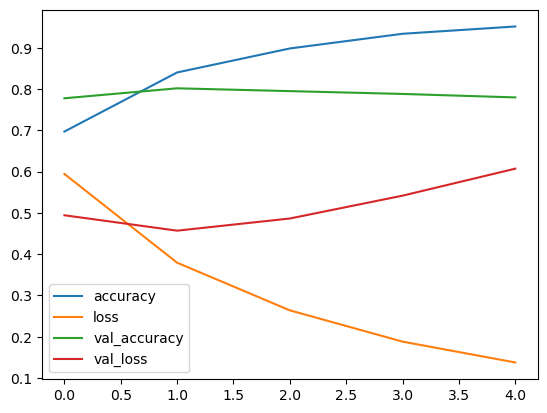

In [194]:
pd.DataFrame(history_1.history).plot()

In [195]:
### we have the bad score in the dense layer. So we are buiulding the RNN using the LSMT
inputs= tf.keras.layers.Input(shape=(0,),dtype=tf.string)
x=text_vector(inputs)
x=embedding_vector(x)
x=tf.keras.layers.LSTM(84)(x)
outputs=tf.keras.layers.Dense(1,activation="sigmoid")(x)
model_2=tf.keras.Model(inputs,outputs,name="model_2_lstm")
model_2.summary()


Model: "model_2_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)     │ (None, 0)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_15           │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_8 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 84)             │        71,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,351,653 (5.16 MB)

 Trainable params: 1,351,653 (5.16 MB)

 Non-trainable params: 0 (0.00 B)

In [196]:
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [197]:
history_2=model_2.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=5)

Epoch 1/5


179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8615 - loss: 0.2956 - val_accuracy: 0.7710 - val_loss: 0.6721
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9613 - loss: 0.1100 - val_accuracy: 0.7642 - val_loss: 0.8074
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9727 - loss: 0.0789 - val_accuracy: 0.7374 - val_loss: 1.0462
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9726 - loss: 0.0627 - val_accuracy: 0.7369 - val_loss: 1.3267
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9771 - loss: 0.0535 - val_accuracy: 0.7222 - val_loss: 1.3270


In [198]:
test_model_1=checking_score(model_2,x_val,y_val)
test_model_1

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


,Recall,Precision,Accuracy,f1_score
0,0.737164,0.657579,0.722164,0.695101


Model 3: GRU
Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.

📖 Resource: A full explanation of the GRU cell is beyond the scope of this noteook but I'd suggest the following resources to learn more:

Gated Recurrent Unit Wikipedia page
Understanding GRU networks by Simeon Kostadinov
To use the GRU cell in TensorFlow, we can call the tensorflow.keras.layers.GRU() class.

The architecture of the GRU-powered model will follow the same structure we've been using:

Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
Again, the only difference will be the layer(s) we use between the embedding and the output.

In [199]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vector(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x) 
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

/Users/saisampath/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [200]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
# Fit model
model_3_history = model_3.fit(x_train,
                              y_train,
                              epochs=5,
                              validation_data=(x_val, y_val))

Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6311 - loss: 0.6349 - val_accuracy: 0.7962 - val_loss: 0.4545
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8434 - loss: 0.3636 - val_accuracy: 0.7768 - val_loss: 0.4875
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9133 - loss: 0.2296 - val_accuracy: 0.7815 - val_loss: 0.5456
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9453 - loss: 0.1633 - val_accuracy: 0.7374 - val_loss: 0.8017
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9587 - loss: 0.1249 - val_accuracy: 0.7489 - val_loss: 0.8076


<Axes: >

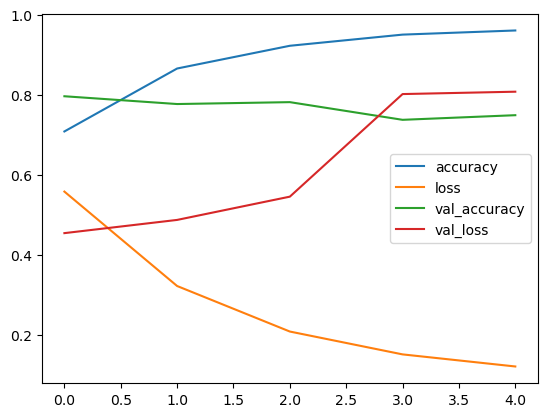

In [201]:
pd.DataFrame(model_3_history.history).plot()

In [202]:
test_model_3=checking_score(model_3,x_val,y_val)
test_model_3

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,Recall,Precision,Accuracy,f1_score
0,0.738386,0.695853,0.74895,0.716489


Model 4: Bidirectonal RNN model
Look at us go! We've already built two RNN's with GRU and LSTM cells. Now we're going to look into another kind of RNN, the bidirectional RNN.

A standard RNN will process a sequence from left to right, where as a bidirectional RNN will process the sequence from left to right and then again from right to left.

Intuitively, this can be thought of as if you were reading a sentence for the first time in the normal fashion (left to right) but for some reason it didn't make sense so you traverse back through the words and go back over them again (right to left).

In practice, many sequence models often see and improvement in performance when using bidirectional RNN's.

However, this improvement in performance often comes at the cost of longer training times and increased model parameters (since the model goes left to right and right to left, the number of trainable parameters doubles).

Okay enough talk, let's build a bidirectional RNN.

Once again, TensorFlow helps us out by providing the tensorflow.keras.layers.Bidirectional class. We can use the Bidirectional class to wrap our existing RNNs, instantly making them bidirectional.

In [203]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vector(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

/Users/saisampath/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [204]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(x_train,
                              y_train,
                              epochs=5,
                              validation_data=(x_val, y_val),
                             )

Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6748 - loss: 0.5925 - val_accuracy: 0.8009 - val_loss: 0.4530
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8601 - loss: 0.3362 - val_accuracy: 0.7700 - val_loss: 0.5241
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9161 - loss: 0.2128 - val_accuracy: 0.7505 - val_loss: 0.6694
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9507 - loss: 0.1403 - val_accuracy: 0.7426 - val_loss: 0.8199
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9644 - loss: 0.1102 - val_accuracy: 0.7579 - val_loss: 0.8023


In [205]:
test_model_4=checking_score(model_4,x_val,y_val)
test_model_4

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


,Recall,Precision,Accuracy,f1_score
0,0.711491,0.72119,0.757878,0.716308


In [206]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vector(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_5.summary()

/Users/saisampath/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_5_Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)     │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_15           │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 11, 32)         │        20,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_6          │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,300,545 (4.96 MB)

 Trainable params: 1,300,545 (4.96 MB)

 Non-trainable params: 0 (0.00 B)

In [207]:
# Fit the model
model_5_history = model_5.fit(x_train,
                              y_train,
                              epochs=5,
                              validation_data=(x_val, y_val))

Epoch 1/5


179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6360 - loss: 0.6443 - val_accuracy: 0.7862 - val_loss: 0.4807
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8343 - loss: 0.3950 - val_accuracy: 0.7936 - val_loss: 0.4683
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9182 - loss: 0.2313 - val_accuracy: 0.7789 - val_loss: 0.5332
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9577 - loss: 0.1362 - val_accuracy: 0.7694 - val_loss: 0.6165
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9689 - loss: 0.0929 - val_accuracy: 0.7700 - val_loss: 0.6642


In [208]:
test_model_5=checking_score(model_4,x_val,y_val)
test_model_5

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


,Recall,Precision,Accuracy,f1_score
0,0.711491,0.72119,0.757878,0.716308


In [209]:
model_4.save('my_rnn_model.h5')

In [210]:
from tensorflow.keras.preprocessing.text import Tokenizer
import json

# Assuming you have a list of texts for training
training_texts =x_train

# Create and fit the tokenizer
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(training_texts)

# Save the tokenizer
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w') as f:
    f.write(tokenizer_json)


In [211]:

vectorizer = TextVectorization(max_tokens=10000, output_sequence_length=100)
vectorizer.adapt(x_train)

# Define the model
model = tf.keras.Sequential([
    vectorizer,
    Embedding(input_dim=10000, output_dim=128, mask_zero=True),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(64),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_16           │ ?                      │   0 (unbuilt) │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_9 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [212]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=32)

# Save the model
model.save('my_rnn_model.h5')

Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 16s 82ms/step - accuracy: 0.6842 - loss: 0.5913 - val_accuracy: 0.8025 - val_loss: 0.4523
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.8652 - loss: 0.3339 - val_accuracy: 0.7957 - val_loss: 0.4920
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.9232 - loss: 0.2132 - val_accuracy: 0.7747 - val_loss: 0.6089
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.9448 - loss: 0.1551 - val_accuracy: 0.7694 - val_loss: 0.7941
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.9631 - loss: 0.1157 - val_accuracy: 0.7542 - val_loss: 0.8404


In [213]:
import random
random_val=random.choice(x_train)


In [214]:
pd.Series([random_val])


0    FedEx will no longer transport bioterror patho...
dtype: object

In [215]:
model.predict(pd.Series([random_val]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


array([[0.6141461]], dtype=float32)

In [216]:
model.predict(x_val)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


array([[1.2020782e-02],
       [2.0017574e-02],
       [1.0982639e-03],
       ...,
       [7.8684452e-04],
       [7.0413917e-01],
       [9.9275428e-01]], dtype=float32)

In [217]:
vectorizer = tf.keras.layers.TextVectorization(max_tokens=10000, output_sequence_length=100)

vectorizer.adapt(x_train)

# Save the vectorizer
vectorizer_config = vectorizer.get_config()
vectorizer_weights = vectorizer.get_weights()

# Save to disk
vectorizer_save_path = '/Users/saisampath/Sentimental_analysis/vectorizer_config/'
tf.saved_model.save(vectorizer, vectorizer_save_path)

INFO:tensorflow:Assets written to: /Users/saisampath/Sentimental_analysis/vectorizer_config/assets


INFO:tensorflow:Assets written to: /Users/saisampath/Sentimental_analysis/vectorizer_config/assets
